# Waste identification with instance segmentation in TensorFlow

Welcome to the Instance Segmentation Colab! This notebook will take you through the steps of running an "out-of-the-box" Mask RCNN Instance Segmentation model on image from TF Model Garden.

To finish this task, a proper path for the saved models and a single image needs to be provided. The path to the labels on which the models are trained is in the waste_identification_ml directory inside the Tensorflow Model Garden repository. The label files are inferred automatically for both models.

In [ ]:
# #Clean up the project for tensorflow compatibility
# !pip uninstall -y tensorflow tensorflow-object-detection-api tf-slim

# !rm -rf ~/.cache/pip  # Clear pip cache
# !rm -rf models  # Delete old version

# !pip uninstall -y tensorflow-object-detection-api
# !pip uninstall -y tf-models-official 

In [14]:
%%bash
pip install --upgrade pip
pip install tensorflow
pip install tf_slim

  Using cached tf_slim-1.1.0-py2.py3-none-any.whl.metadata (1.6 kB)
Using cached tf_slim-1.1.0-py2.py3-none-any.whl (352 kB)


The Object Detection API requires compiled Protobuf files. Run this command in the models/research/ directory:

install dependencies

Do NOT use pip install tensorflow-object-detection-api – it's outdated

In [ ]:
!pip show tensorflow


## Imports and Setup

To visualize the images with the proper detected boxes and segmentation masks, we will use the TensorFlow Object Detection API. To install it we will clone the repo.

In [ ]:
import sys
import os
import csv
from typing import Any, TypedDict, Callable
import cv2
import logging
import numpy as np
import matplotlib.pyplot as plt

logging.disable(logging.WARNING)

import tensorflow as tf

%matplotlib inline

2025-02-28 00:16:14.255301: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
print("TF Version:", tf.__version__)
print("TF Slim Version:", tf_slim.__version__)

TF Version: 2.16.2


In [1]:
# Clone the tensorflow models repository.
!git clone --depth 1 https://github.com/tensorflow/models 2>/dev/null

In [ ]:
%%bash
cd models/research/

protoc object_detection/protos/*.proto --python_out=.


In [ ]:
# Add these paths (adjust to your models directory location)
models_dir = os.path.abspath("./models")  # Path to your cloned models repo
research_path = os.path.join(models_dir, "research")
slim_path = os.path.join(research_path, "slim")

sys.path.insert(0, research_path)
sys.path.insert(0, slim_path)

# Verify paths
print(f"Research path: {research_path}")
print(f"Slim path: {slim_path}")

Research path: /Users/oysterable/delete/recyclables-detector/models/research
Slim path: /Users/oysterable/delete/recyclables-detector/models/research/slim


In [6]:

# Test if the module is accessible
from object_detection.utils import visualization_utils as viz_utils
print("Success!")

Success!


In [7]:
sys.path.append('./models/research')

from object_detection.utils import ops as utils_ops
from object_detection.utils import visualization_utils as viz_utils

print(utils_ops.__file__)  # Should point to your new models/research/... location

/Users/oysterable/delete/recyclables-detector/models/research/object_detection/utils/ops.py


In [ ]:
#@title Utilities
class ItemDict(TypedDict):
  id: int
  name: str
  supercategory: str


def load_model(model_path: str) -> Callable:
    """Loads a TensorFlow SavedModel and returns a function for making predictions.

    Args:
      model_path: Path to the TensorFlow SavedModel.

    Returns:
      A function that can be used to make predictions.
    """
    try:
      print('loading model...')
      model = tf.saved_model.load(model_path)
      print('model loaded!')
      detection_fn = model.signatures['serving_default']
      return detection_fn
    except (OSError, ValueError, KeyError) as e:
        print(f"Error loading model: {e}")
        raise



def perform_detection(model: Callable, image: np.ndarray) -> dict[str, np.ndarray]:
    """Perform Mask R-CNN object detection on an image using the specified model.

    Args:
        model: A function that can be used to make predictions.
        image: A NumPy array representing the image to be processed.

    Returns:
        Detection results, where keys are output names and values are NumPy arrays.
    """
    detection_results = model(image)
    detection_results = {key: value.numpy() for key, value in detection_results.items()}
    return detection_results
  


def _read_csv_to_list(file_path: str) -> list[str]:
  """Reads a CSV file and returns its contents as a list.

  This function reads the given CSV file, skips the header, and assumes
  there is only one column in the CSV. It returns the contents as a list of
  strings.

  Args:
      file_path: The path to the CSV file.

  Returns:
      The contents of the CSV file as a list of strings.
  """
  data_list = []
  with open(file_path, 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
      data_list.append(row[0])  # Assuming there is only one column in the CSV
  return data_list


def _categories_dictionary(objects: list[str]) -> dict[int, ItemDict]:
  """This function takes a list of objects and returns a dictionaries.

  A dictionary of objects, where each object is represented by a dictionary
  with the following keys:
    - id: The ID of the object.
    - name: The name of the object.
    - supercategory: The supercategory of the object.

  Args:
    objects: A list of strings, where each string is the name of an
      object.

  Returns:
    A tuple of two dictionaries, as described above.
  """
  category_index = {}
  for num, obj_name in enumerate(objects, start=1):
    obj_dict = {'id': num, 'name': obj_name, 'supercategory': 'objects'}
    category_index[num] = obj_dict
  return category_index


def load_labels(labels_path: str) -> tuple[list[str], dict[int, ItemDict]]:
    """
    Load label mappings from a CSV file and generate category indices.

    Args:
        labels_path (str): Path to the CSV file containing label mappings.

    Returns:
        Tuple[Dict[int, dict], Dict[int, dict]]:
        - A dictionary mapping category IDs to label details.
        - A processed category index dictionary.
    """
    labels = _read_csv_to_list(labels_path)
    category_index = _categories_dictionary(labels)
    return labels, category_index


def preprocess_image(path: str, height: int, width: int) -> tuple[np.ndarray, np.ndarray]:
    """
    Load an image from a file into a NumPy array, resize it, and expand dimensions for batch processing.

    Args:
        path: The file path to the image.
        height: Desired height of the resized image.
        width: Desired width of the resized image.

    Returns:
        original_image: The original image with shape (original_height, original_width, 3).
        resized_image: The resized image with shape (1, height, width, 3), suitable for model input.
    """
    original_image = cv2.imread(path)
    if original_image is None:
        raise FileNotFoundError(f"Image not found at path: {path}")

    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    
    # resized_image = cv2.resize(original_image, (width, height), interpolation=cv2.INTER_AREA)
    resized_image = cv2.resize(original_image, (width, height))
    resized_image = np.expand_dims(resized_image, axis=0)

    return original_image, resized_image


def filter_detection(results: dict[str, np.ndarray], valid_indices: np.ndarray) -> dict[str, np.ndarray]:
  """Filter the detection results based on the valid indices.

  Args:
    results: The detection results from the model.
    valid_indices: The indices of the valid detections.

  Returns:
    The filtered detection results.
  """
  if np.array(valid_indices).dtype == bool:
    new_num_detections = int(np.sum(valid_indices))
  else:
    new_num_detections = len(valid_indices)

  # Define the keys to filter
  keys_to_filter = [
      'detection_masks',
      'detection_masks_resized',
      'detection_masks_reframed',
      'detection_classes',
      'detection_boxes',
      'normalized_boxes',
      'detection_scores',
      'detection_classes_names',
  ]

  # Apply filtering to the specified keys
  filtered_output = {}

  for key in keys_to_filter:
    if key in results:
      if key == 'detection_masks':
        filtered_output[key] = results[key][:, valid_indices, :, :]
      elif key in ['detection_masks_resized', 'detection_masks_reframed']:
        filtered_output[key] = results[key][valid_indices, :, :]
      elif key in ['detection_boxes', 'normalized_boxes']:
        filtered_output[key] = results[key][:, valid_indices, :]
      elif key in ['detection_classes', 'detection_scores', 'detection_classes_names']:
        filtered_output[key] = results[key][:, valid_indices]
  filtered_output['num_detections'] = np.array([new_num_detections])

  return filtered_output



def reframe_masks(results: dict[str, np.ndarray], boxes: str, height: int, width: int) -> np.ndarray:
  """Reframe the masks to an image size.

  Args:
    results: The detection results from the model.
    boxes: The detection boxes.
    height: The height of the original image.
    width: The width of the original image.

  Returns:
    The reframed masks.
  """
  detection_masks = results['detection_masks'][0]
  detection_boxes = results[boxes][0]
  detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
      detection_masks, detection_boxes, height, width
  )
  detection_masks_reframed = tf.cast(detection_masks_reframed > 0.5, np.uint8)
  detection_masks_reframed = detection_masks_reframed.numpy()
  return detection_masks_reframed


  

def _calculate_area(mask: np.ndarray) -> int:
  """Calculate the area of the mask.

  Args:
    mask: The mask to calculate the area of.

  Returns:
    The area of the mask.
  """
  return np.sum(mask)


def _calculate_iou(mask1: np.ndarray, mask2: np.ndarray) -> float:
  """Calculate the intersection over union (IoU) between two masks.

  Args:
    mask1: The first mask.
    mask2: The second mask.

  Returns:
    The intersection over union (IoU) between the two masks.
  """
  intersection = np.logical_and(mask1, mask2).sum()
  union = np.logical_or(mask1, mask2).sum()
  return intersection / union if union != 0 else 0


def _is_contained(mask1: np.ndarray, mask2: np.ndarray) -> bool:
  """Check if mask1 is entirely contained within mask2.

  Args:
    mask1: The first mask.
    mask2: The second mask.

  Returns:
    True if mask1 is entirely contained within mask2, False otherwise.
  """
  return np.array_equal(np.logical_and(mask1, mask2), mask1)


def filter_masks(masks: np.ndarray, iou_threshold=0.8, area_threshold=None) -> np.ndarray:
  """Filter the overlapping masks.

  Filter the masks based on the area and intersection over union (IoU).

  Args:
    masks: The masks to filter.
    iou_threshold: The threshold for the intersection over union (IoU) between
      two masks.
    area_threshold: The threshold for the area of the mask.

  Returns:
    The indices of the unique masks.
  """
  # Calculate the area for each mask
  areas = np.array([_calculate_area(mask) for mask in masks])

  # Sort the masks based on area in descending order
  sorted_indices = np.argsort(areas)[::-1]
  sorted_masks = masks[sorted_indices]
  sorted_areas = areas[sorted_indices]

  unique_indices = []

  for i, mask in enumerate(sorted_masks):
    if (area_threshold is not None and sorted_areas[i] > area_threshold) or sorted_areas[i] < 4000:
      continue

    keep = True
    for j in range(i):
      if _calculate_iou(mask, sorted_masks[j]) > iou_threshold or _is_contained(
          mask, sorted_masks[j]
      ):
        keep = False
        break
    if keep:
      unique_indices.append(sorted_indices[i])

  return unique_indices


def adjust_image_size(height: int, width: int, min_size: int) -> tuple[int, int]:
  """Adjust the image size to ensure both dimensions are at least 1024.

  Args:
    height: The height of the image.
    width: The width of the image.
    min_size: Minimum size of the image dimension needed.

  Returns:
    The adjusted height and width of the image.
  """
  if height < min_size or width < min_size:
    return height, width

  # Calculate the scale factor to ensure both dimensions remain at least 1024
  scale_factor = min(height / min_size, width / min_size)

  new_height = int(height / scale_factor)
  new_width = int(width / scale_factor)

  return new_height, new_width


def display_bbox_masks_labels(
    result: dict[Any, np.ndarray],
    image: np.ndarray,
    category_index: dict[int, dict[str, str]],
    threshold: float,
) -> None:
  """Saves an image with visualized bounding boxes, labels, and masks.

  This function takes the output from Mask R-CNN, copies the original image,
  and applies visualizations of detection boxes, classes, and scores.
  If available, it also applies segmentation masks. The result is an image that
  juxtaposes the original with the annotated version, saved to the specified
  folder.

  Args:
    result: The output from theMask RCNN model, expected to contain detection
      boxes, classes, scores, reframed detection masks, etc.
    image: The original image as a numpy array.
    file_name: The filename for saving the output image.
    folder: The folder path where the output image will be saved.
    category_index: A dictionary mapping class IDs to class labels.
    threshold: Value between 0 and 1 to filter out the prediction results.
  """
  image_new = image.copy()
  image_new = cv2.cvtColor(image_new, cv2.COLOR_BGR2RGB)
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_new,
      result['normalized_boxes'][0],
      (result['detection_classes'][0] + 0).astype(int),
      result['detection_scores'][0],
      category_index=category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=100,
      min_score_thresh=threshold,
      agnostic_mode=False,
      instance_masks=result.get('detection_masks_reframed', None),
      line_thickness=4,
  )
  return image_new

In [10]:
# Path to a sample image stored in the repo.
IMAGES_FOR_TEST = {
    'Image1': (
        'models/official/projects/waste_identification_ml/pre_processing/'
        'config/sample_images/image_2.png'
    )
}

## Import and load pre-trained models.

In [11]:
# %%bash
# wget https://storage.googleapis.com/tf_model_garden/vision/\
# waste_identification_ml/Jan2025_ver2_merged_1024_1024.zip -q

# unzip Jan2025_ver2_merged_1024_1024.zip > /dev/null 2>&1

In [ ]:
def list_tensors_from_saved_model(model_path):
    with tf.Session() as sess:
        meta_graph = tf.saved_model.loader.load(sess, [tf.saved_model.SERVING], model_path)
        tensor_names = [tensor.name for op in sess.graph.get_operations() for tensor in op.values()]
    return tensor_names

# Replace with your model path
model_path = "Jan2025_ver2_merged_1024_1024/"
tensor_names = list_tensors_from_saved_model(model_path)

# Print all tensors
print("Available tensors:")
for name in tensor_names:
    print(name)

In [ ]:
detection_fn = load_model('Jan2025_ver2_merged_1024_1024/')



loading model...
model loaded!


## Load label map data

Label maps correspond index numbers to category names, so that when our convolution network predicts 5, we know that this corresponds to airplane. Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine.

We will load our labels from the same repository that we loaded the TF Object Detection API from.

In [14]:
LABELS_PATH = (
    'models/official/projects/waste_identification_ml/pre_processing/'
    'config/data/45_labels.csv'
)

labels, category_index = load_labels(LABELS_PATH)

## Loading and pre-process an image

Let's try the model on a simple image.

Note: when using images with an alpha channel, the model expect 3 channels images and the alpha will count as a 4th.

In [15]:
# The model is trained on 1024 x 1024 image dimensions
HEIGHT = 1024
WIDTH = 1024
IMAGE_PATH = (
    'models/official/projects/waste_identification_ml/pre_processing/'
    'config/sample_images/image_2.png'
)

In [17]:
# Preprocess the image.
original_image, resized_image = preprocess_image(IMAGE_PATH, HEIGHT, WIDTH)
input_tensor = tf.convert_to_tensor(resized_image, dtype=tf.uint8)

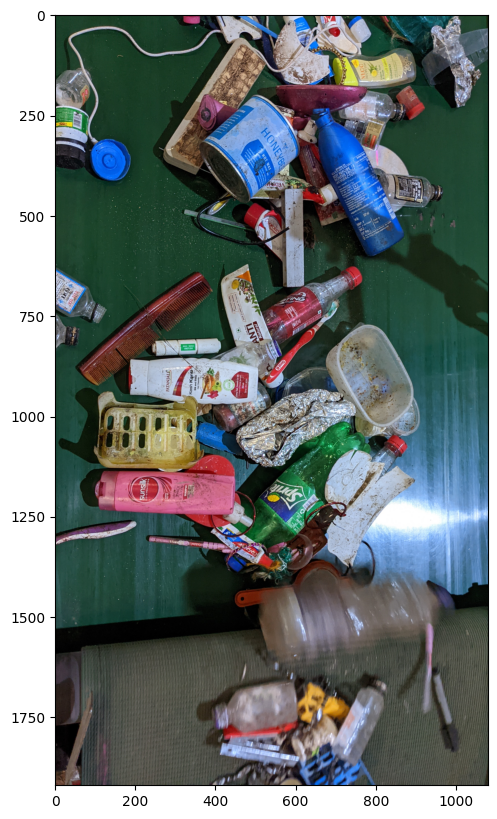

In [18]:
%matplotlib inline
plt.figure(figsize=(10,10))
plt.imshow(original_image)
plt.show()

## Perform inference

In [ ]:
# Running inference with both the models.

result = perform_detection(detection_fn, input_tensor)

print("Detection result:", result)

Detection result: {'num_detections': array([51], dtype=int32), 'detection_masks': array([[[[1.6268062e-03, 2.5534192e-03, 3.2781619e-03, ...,
          4.0077492e-05, 2.4654604e-05, 2.5440846e-05],
         [2.9898125e-03, 6.0415259e-03, 1.3786130e-02, ...,
          5.0449307e-05, 2.8441324e-05, 2.3403973e-05],
         [7.1671000e-03, 2.5643792e-02, 7.8665003e-02, ...,
          2.5368648e-04, 4.9725397e-05, 3.1726035e-05],
         ...,
         [8.8061841e-04, 3.1370926e-03, 1.3480027e-02, ...,
          3.9745229e-03, 5.6423782e-04, 1.7397523e-04],
         [3.1663821e-04, 7.5548521e-04, 2.1050961e-03, ...,
          7.8364037e-04, 1.7716883e-04, 1.1136005e-04],
         [1.8448476e-04, 3.2191313e-04, 6.1698572e-04, ...,
          2.5401544e-04, 1.2810710e-04, 9.4722214e-05]],

        [[9.2050171e-04, 6.5641635e-04, 5.0191605e-04, ...,
          2.2324508e-01, 8.7079844e-03, 1.5333325e-03],
         [8.2104269e-04, 7.1941887e-04, 4.4680104e-04, ...,
          8.1009042e-01, 5.074

In [20]:

print(f'Total number of detections: {result["num_detections"][0]}')
print(result.keys())

Total number of detections: 51
dict_keys(['num_detections', 'detection_masks', 'detection_boxes', 'image_info', 'detection_scores', 'detection_classes'])


## Process the output to remove overlapping or duplicate predictions.

In [21]:
# Prediction threshold.
PREDICTION_THRESHOLD = 0.50
area_threshold = None

if result["num_detections"][0]:
  scores = result["detection_scores"][0]
  filtered_indices = scores > PREDICTION_THRESHOLD
  result = filter_detection(result, filtered_indices)
  print(
      "Total number of detections after threshold:"
      f" {result['num_detections'][0]}"
  )

if result["num_detections"][0]:
  # Normalize the bounding boxes according to the resized image size.
  result["normalized_boxes"] = result["detection_boxes"].copy()
  result["normalized_boxes"][:, :, [0, 2]] /= HEIGHT
  result["normalized_boxes"][:, :, [1, 3]] /= WIDTH

  # Adjust the image size to ensure both dimensions are at least 1024
  # for saving images with bbx and masks.
  height_plot, width_plot = adjust_image_size(
      original_image.shape[0], original_image.shape[1], 1024
  )
  
  image_plot = cv2.resize(
      original_image,
      (width_plot, height_plot),
      interpolation=cv2.INTER_AREA,
  )
  # Reframe the masks to the new size.
  result["detection_masks_reframed"] = reframe_masks(
      result, "normalized_boxes", height_plot, width_plot
  )

  # Filter the prediction results based on the area threshold and
  # remove the overlapping masks.
  unique_indices = filter_masks(
      result["detection_masks_reframed"],
      iou_threshold=0.08,
      area_threshold=area_threshold,
  )
  result = filter_detection(result, unique_indices)
  print(
      "Total number of detections after filtering:"
      f" {result['num_detections'][0]}"
  )

Total number of detections after threshold: 24
Total number of detections after filtering: 20


## Visualization of masks

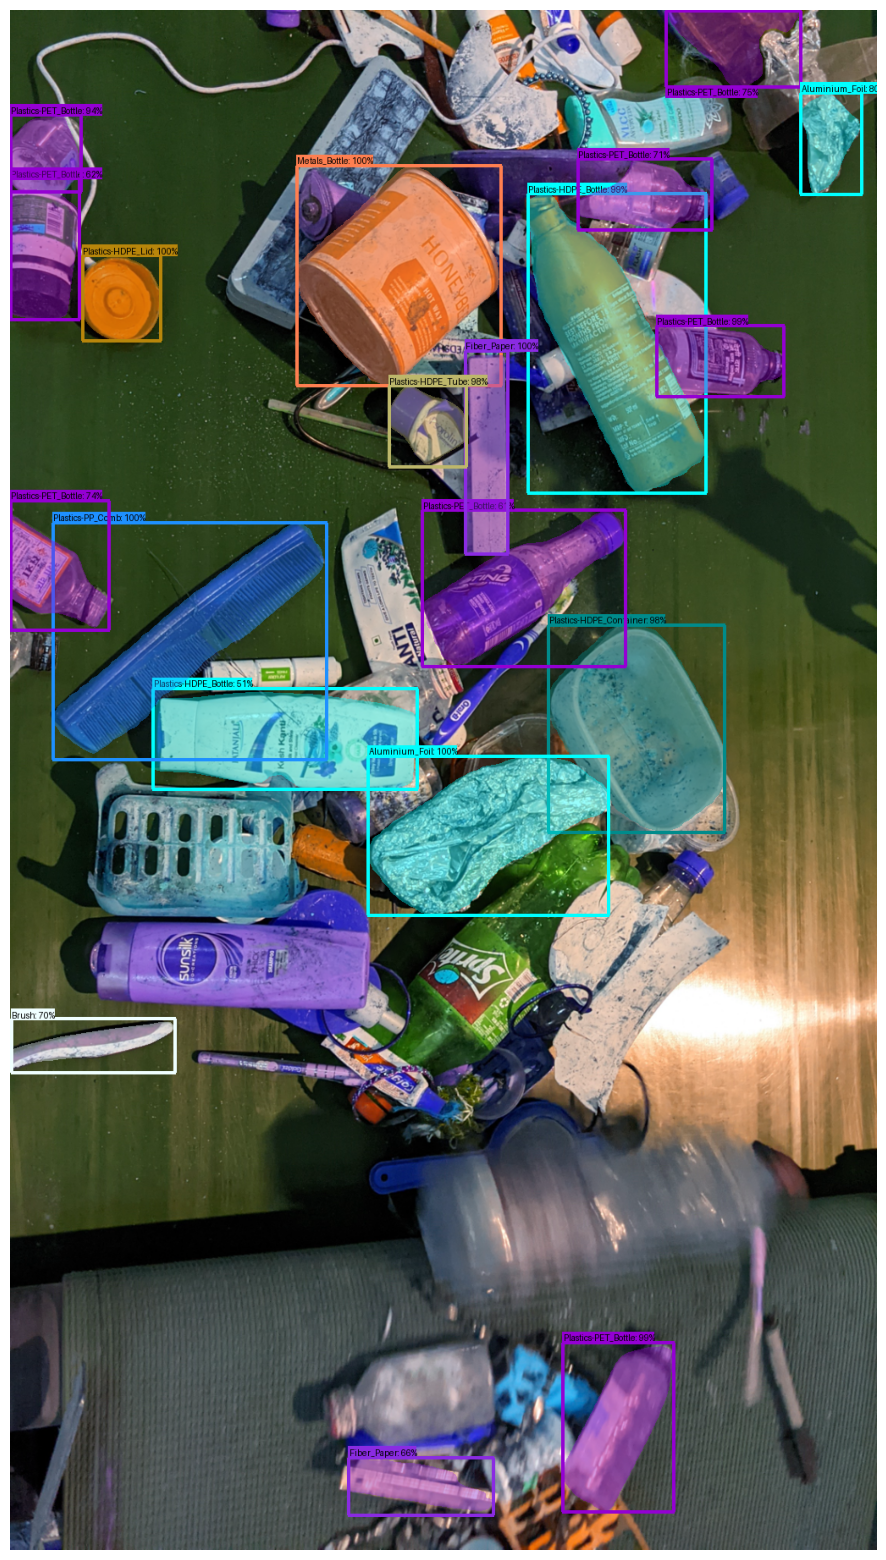

In [22]:
labeled_image = display_bbox_masks_labels(
    result,
    image_plot,
    category_index,
    PREDICTION_THRESHOLD
)
%matplotlib inline
plt.figure(figsize=(20,20))
plt.axis('off')
plt.imshow(labeled_image)